# Step 1: Data Download and organization
 Please see the Project Proposal in the repo for information on goals, data sources, and research questions. 

This notebook is the first step in Kealie Pretzlav's Springboard Capstone 2 project. 
This notebook downloads the appropriate datasets, merges them, and checks for missing values and duplicates. 
Further data processing will occur in future steps. 

In [7]:
import pandas as pd
import datetime as dt
import numpy as np

import geopandas as gpd
from shapely.geometry import Point
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

import os
from dotenv import load_dotenv
import requests

## Flood Data
Flood occurence dataset from NOAA National Center for Environmental Information: https://www.ncdc.noaa.gov/stormevents/
Analysis uses storms which are labeled "Flood" or "Flash Flood". The database also includes other storm events such as tornados, hurricanes, and wind. 

Data is downloaded for 1996 to present; data is not available prior to 1996. 

In [8]:
### download storm data
storm_url = 'https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/'
file_list = list(pd.read_html(storm_url, skiprows=2)[0]['Parent Directory'].dropna())
years_to_dl = range(1996, 2022, 1) ##download data for 1996 on, no flood data prior
filename_to_dl = [f for f in file_list if 'details-ftp_v1.0_d' in f]

##initialize data subset rather than downloading whole storm event dataset
df_flood = pd.DataFrame()
flood_types = ['Flood', 'Flash Flood']

for year in years_to_dl:
    filename = [s for s in file_list if 'details-ftp_v1.0_d' + str(year) in s][0]
    df_flood_year = pd.read_csv(storm_url + filename, dtype='object')
    df_flood = pd.concat([df_flood, df_flood_year[df_flood_year['EVENT_TYPE'].isin(flood_types)]])
    # print(year)

df_flood.head()

BEGIN_YEARMONTH BEGIN_DAY BEGIN_TIME END_YEARMONTH END_DAY END_TIME  \
1           199610        21        900        199610      21      900   
25          199601        24       1200        199601      24     1200   
34          199601        22        700        199601      31     1159   
44          199601        26       2330        199601      27      630   
69          199601        19        830        199601      20      700   

   EPISODE_ID EVENT_ID           STATE STATE_FIPS  ... END_RANGE END_AZIMUTH  \
1     2052748  5570362        OKLAHOMA         40  ...       NaN         NaN   
25    1000569  5536059         INDIANA         18  ...       NaN         NaN   
34    1002242  5549485        KENTUCKY         21  ...       NaN         NaN   
44    2404288  5537263  NORTH CAROLINA         37  ...       NaN         NaN   
69    2057213  5583210        NEW YORK         36  ...       NaN         NaN   

   END_LOCATION BEGIN_LAT BEGIN_LON END_LAT END_LON  \
1        DURANT       NaN       NaN     NaN     NaN   
25          NaN       NaN       NaN     NaN     NaN   
34          NaN       NaN       NaN     NaN     NaN   
44          NaN       NaN       NaN     NaN     NaN   
69   COUNTYWIDE       NaN       NaN     NaN     NaN   

                                    EPISODE_NARRATIVE EVENT_NARRATIVE  \
1   Flash flood waters washed out a small bridge a...             NaN   
25  On the 23rd, many areas received around an inc...             NaN   
34  Snowmelt and heavy rain caused widespread floo...             NaN   
44  Prolonged rain became heavier following the ic...             NaN   
69                                                NaN             NaN   

   DATA_SOURCE  
1          PDC  
25         PDC  
34         PDC  
44         PDC  
69         PDC  

[5 rows x 51 columns]

In [9]:
#view the data
df_flood.head().T

1   \
BEGIN_YEARMONTH                                                199610   
BEGIN_DAY                                                          21   
BEGIN_TIME                                                        900   
END_YEARMONTH                                                  199610   
END_DAY                                                            21   
END_TIME                                                          900   
EPISODE_ID                                                    2052748   
EVENT_ID                                                      5570362   
STATE                                                        OKLAHOMA   
STATE_FIPS                                                         40   
YEAR                                                             1996   
MONTH_NAME                                                    October   
EVENT_TYPE                                                Flash Flood   
CZ_TYPE                                                             C   
CZ_FIPS                                                            13   
CZ_NAME                                                         BRYAN   
WFO                                                               OUN   
BEGIN_DATE_TIME                                    21-OCT-96 09:00:00   
CZ_TIMEZONE                                                       CST   
END_DATE_TIME                                      21-OCT-96 09:00:00   
INJURIES_DIRECT                                                     0   
INJURIES_INDIRECT                                                   0   
DEATHS_DIRECT                                                       0   
DEATHS_INDIRECT                                                     0   
DAMAGE_PROPERTY                                                   NaN   
DAMAGE_CROPS                                                      NaN   
SOURCE                                                            NaN   
MAGNITUDE                                                         NaN   
MAGNITUDE_TYPE                                                    NaN   
FLOOD_CAUSE                                                       NaN   
CATEGORY                                                          NaN   
TOR_F_SCALE                                                       NaN   
TOR_LENGTH                                                        NaN   
TOR_WIDTH                                                         NaN   
TOR_OTHER_WFO                                                     NaN   
TOR_OTHER_CZ_STATE                                                NaN   
TOR_OTHER_CZ_FIPS                                                 NaN   
TOR_OTHER_CZ_NAME                                                 NaN   
BEGIN_RANGE                                                       NaN   
BEGIN_AZIMUTH                                                     NaN   
BEGIN_LOCATION                                                 DURANT   
END_RANGE                                                         NaN   
END_AZIMUTH                                                       NaN   
END_LOCATION                                                   DURANT   
BEGIN_LAT                                                         NaN   
BEGIN_LON                                                         NaN   
END_LAT                                                           NaN   
END_LON                                                           NaN   
EPISODE_NARRATIVE   Flash flood waters washed out a small bridge a...   
EVENT_NARRATIVE                                                   NaN   
DATA_SOURCE                                                       PDC   

                                                                   25  \
BEGIN_YEARMONTH                                                199601   
BEGIN_DAY                                                          24   
BEGIN_TIME                                         

In [10]:
## take a look at flood causes

df_flood.describe().T
df_flood['FLOOD_CAUSE'].value_counts()

FLOOD_CAUSE
Heavy Rain                      88730
Heavy Rain / Snow Melt           4917
Heavy Rain / Tropical System     2431
Heavy Rain / Burn Area            738
Ice Jam                           698
Dam / Levee Break                 231
Planned Dam Release               175
Name: count, dtype: int64

In [11]:
##change col names to lowercase
df_flood.columns = df_flood.columns.str.lower()
df_flood.columns


Index(['begin_yearmonth', 'begin_day', 'begin_time', 'end_yearmonth',
       'end_day', 'end_time', 'episode_id', 'event_id', 'state', 'state_fips',
       'year', 'month_name', 'event_type', 'cz_type', 'cz_fips', 'cz_name',
       'wfo', 'begin_date_time', 'cz_timezone', 'end_date_time',
       'injuries_direct', 'injuries_indirect', 'deaths_direct',
       'deaths_indirect', 'damage_property', 'damage_crops', 'source',
       'magnitude', 'magnitude_type', 'flood_cause', 'category', 'tor_f_scale',
       'tor_length', 'tor_width', 'tor_other_wfo', 'tor_other_cz_state',
       'tor_other_cz_fips', 'tor_other_cz_name', 'begin_range',
       'begin_azimuth', 'begin_location', 'end_range', 'end_azimuth',
       'end_location', 'begin_lat', 'begin_lon', 'end_lat', 'end_lon',
       'episode_narrative', 'event_narrative', 'data_source'],
      dtype='object')

/var/folders/k2/8b5d5rd53t38_t4lfc676zsr0000gp/T/ipykernel_9574/2766726960.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_flood[flood_numeric_names] = df_flood[flood_numeric_names].apply(pd.to_numeric, errors='ignore')


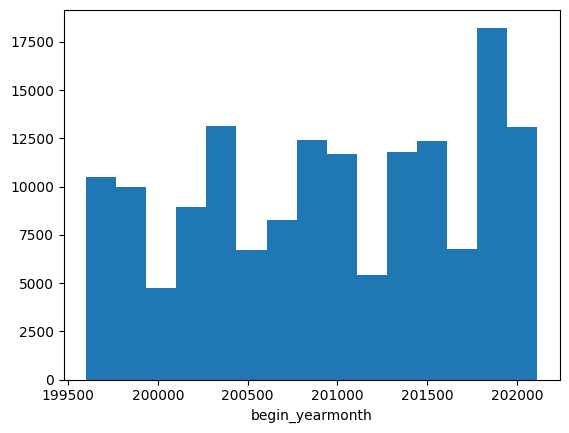

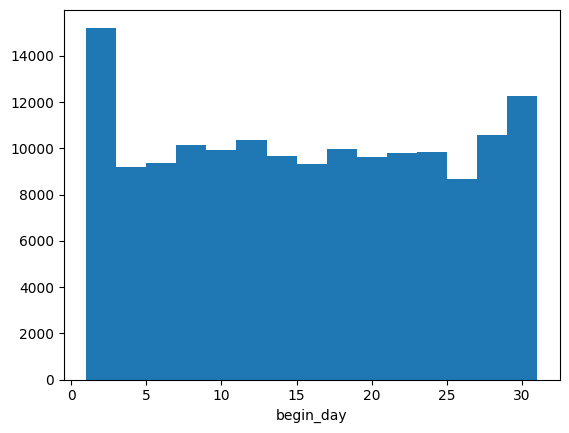

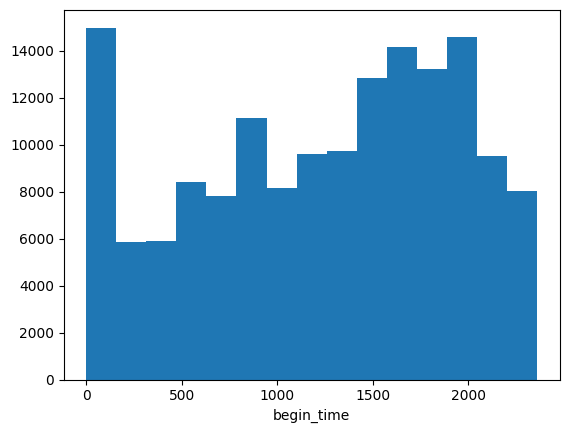

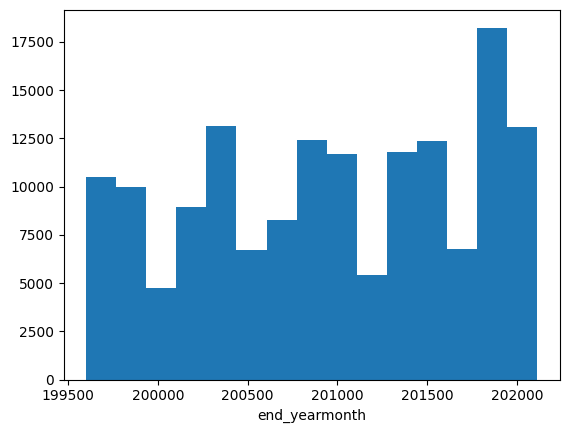

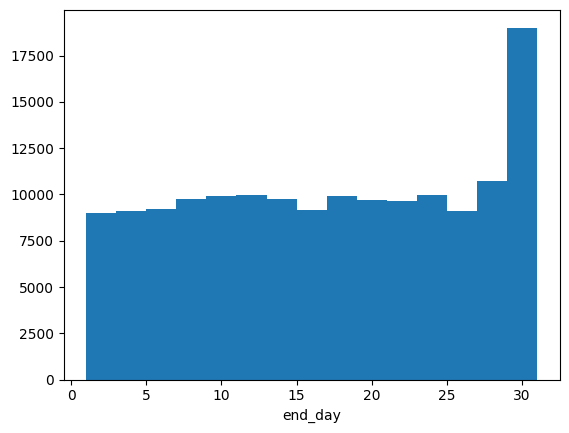

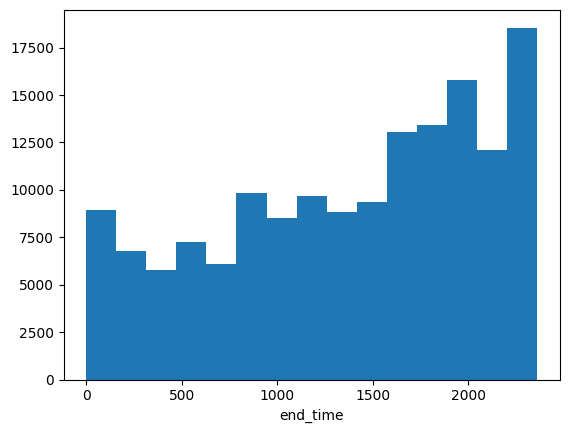

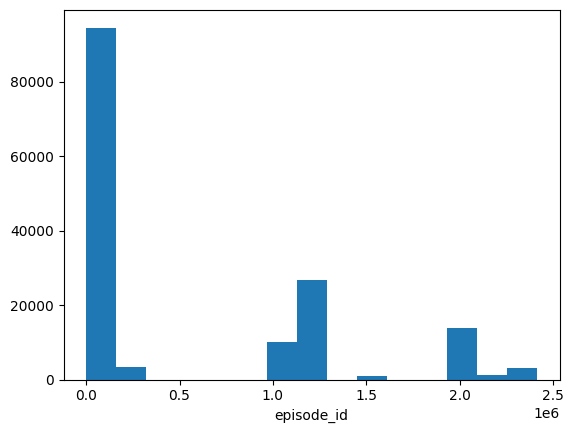

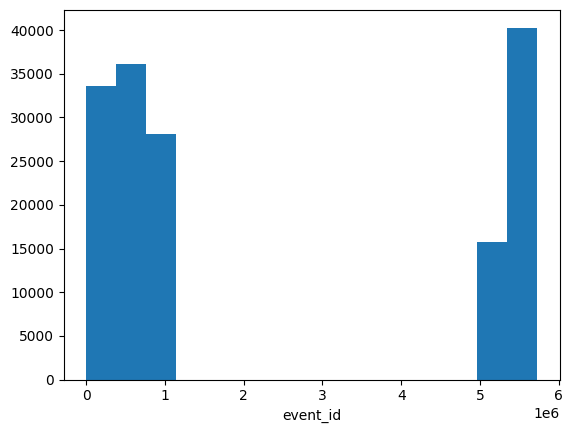

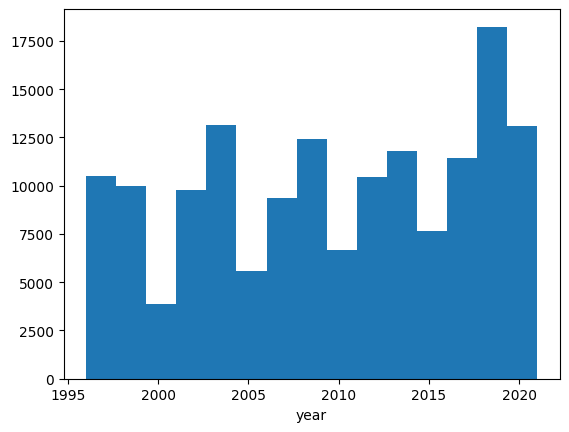

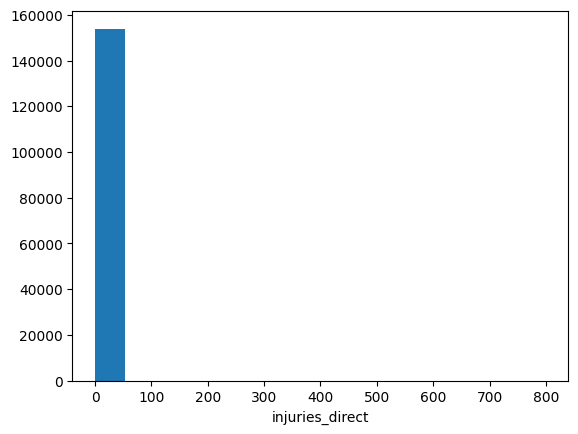

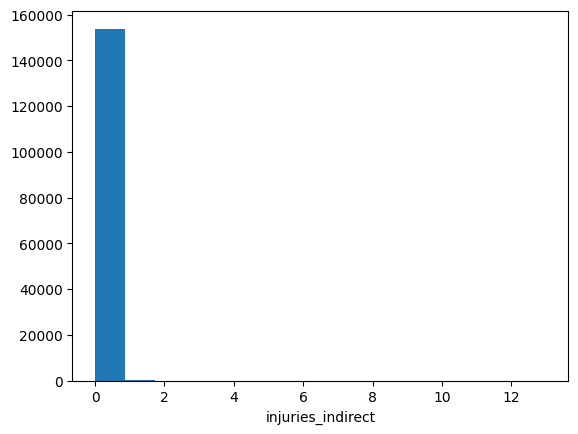

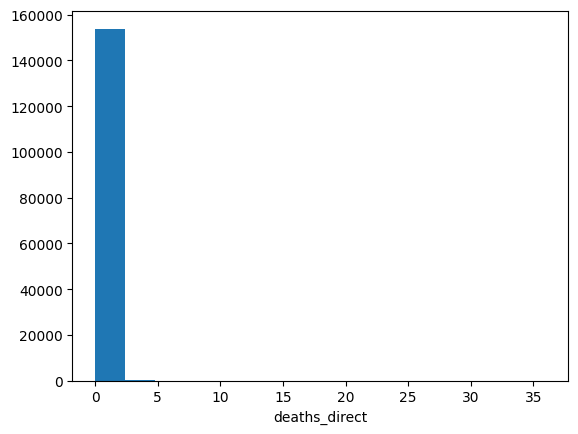

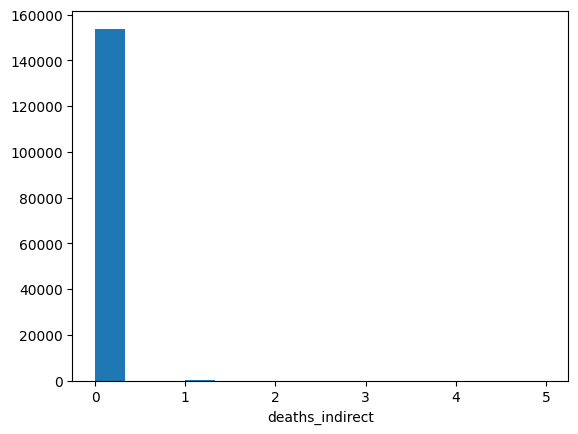

In [12]:
##check for outliers
flood_numeric_names = ['begin_yearmonth', 'begin_day', 'begin_time', 'end_yearmonth',
                       'end_day', 'end_time', 'episode_id', 'event_id','year',
                       'injuries_direct', 'injuries_indirect', 'deaths_direct','deaths_indirect']
df_flood[flood_numeric_names] = df_flood[flood_numeric_names].apply(pd.to_numeric, errors='ignore')
### check numeric outliers
for n in df_flood[flood_numeric_names].columns:
    plt.hist(df_flood[flood_numeric_names][n], bins=15)
    plt.xlabel(n)
    plt.show()



_Things to notice about histograms/outliers_
- Time start and day start suggests a slight bias toward the start/end day and first/end time, suggesting unknown data uses these as defaults
- outlier on injuries_direct, injuries_indirect, deaths_direct, deaths_indirect. Unsure if that is real or unknown data. Appears as though many events just have missing injuries/death data. 


In [13]:
##check for missing values in key columns
df_flood.isna().sum()

begin_yearmonth            0
begin_day                  0
begin_time                 0
end_yearmonth              0
end_day                    0
end_time                   0
episode_id                 0
event_id                   0
state                      0
state_fips                 0
year                       0
month_name                 0
event_type                 0
cz_type                    0
cz_fips                    0
cz_name                    0
wfo                        0
begin_date_time            0
cz_timezone                0
end_date_time              0
injuries_direct            0
injuries_indirect          0
deaths_direct              0
deaths_indirect            0
damage_property        35527
damage_crops           49988
source                 13380
magnitude             153892
magnitude_type        153989
flood_cause            56070
category              153990
tor_f_scale           153990
tor_length            153990
tor_width             153990
tor_other_wfo 

Lots of columns have mostly missing data. Drop columns with more than 100k missing values (tor_ columns are for tornado events). Also drop columns that aren't needed. 

In [14]:
### done need all the data, drop some now to clean up
df_flood = df_flood.dropna(thresh=100000, axis=1)
df_flood_drop = df_flood.drop(['begin_range', 'begin_azimuth', 'begin_location', 'end_range', 'end_azimuth', 'end_location'], axis=1)
##
df_flood_drop.columns

Index(['begin_yearmonth', 'begin_day', 'begin_time', 'end_yearmonth',
       'end_day', 'end_time', 'episode_id', 'event_id', 'state', 'state_fips',
       'year', 'month_name', 'event_type', 'cz_type', 'cz_fips', 'cz_name',
       'wfo', 'begin_date_time', 'cz_timezone', 'end_date_time',
       'injuries_direct', 'injuries_indirect', 'deaths_direct',
       'deaths_indirect', 'damage_property', 'damage_crops', 'source',
       'begin_lat', 'begin_lon', 'end_lat', 'end_lon', 'episode_narrative',
       'event_narrative', 'data_source'],
      dtype='object')

Lat/Long has lots of missing values. How many have both begin and end lat or long missing? 

In [15]:
print('lat counts: ', df_flood_drop[['begin_lat', 'end_lat']].isna().sum(1).value_counts())
print('lon counts: ', df_flood_drop[['begin_lon', 'end_lon']].isna().sum(1).value_counts())
print('all lat/long counts: ', df_flood_drop[['begin_lon', 'end_lon', 'begin_lat', 'end_lat']].isna().sum(1).value_counts())

lat counts:  0    103535
2     50455
Name: count, dtype: int64
lon counts:  0    103535
2     50455
Name: count, dtype: int64
all lat/long counts:  0    103535
4     50455
Name: count, dtype: int64


50k are missing all lat/long info. Isolated to older data? Specific state?

<Axes: >

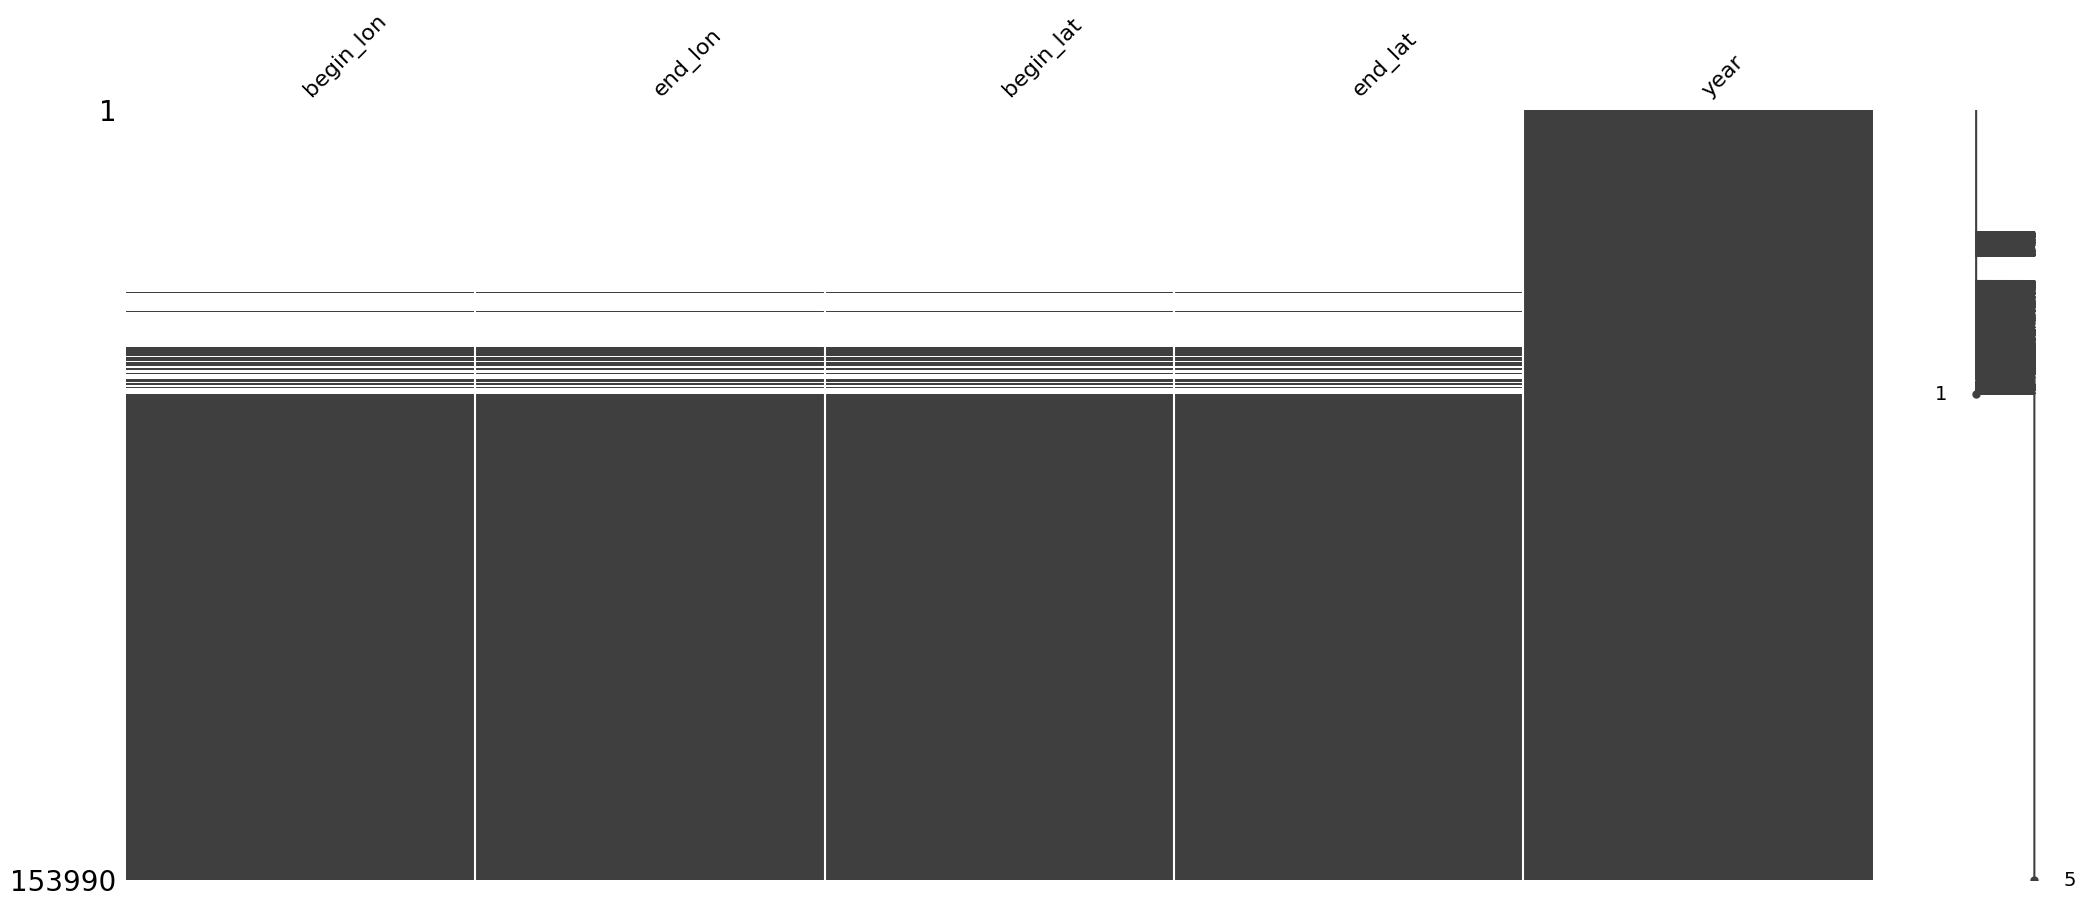

In [16]:
msno.matrix(df_flood_drop[['begin_lon', 'end_lon', 'begin_lat', 'end_lat', 'year']].sort_values('year'))

<Axes: >

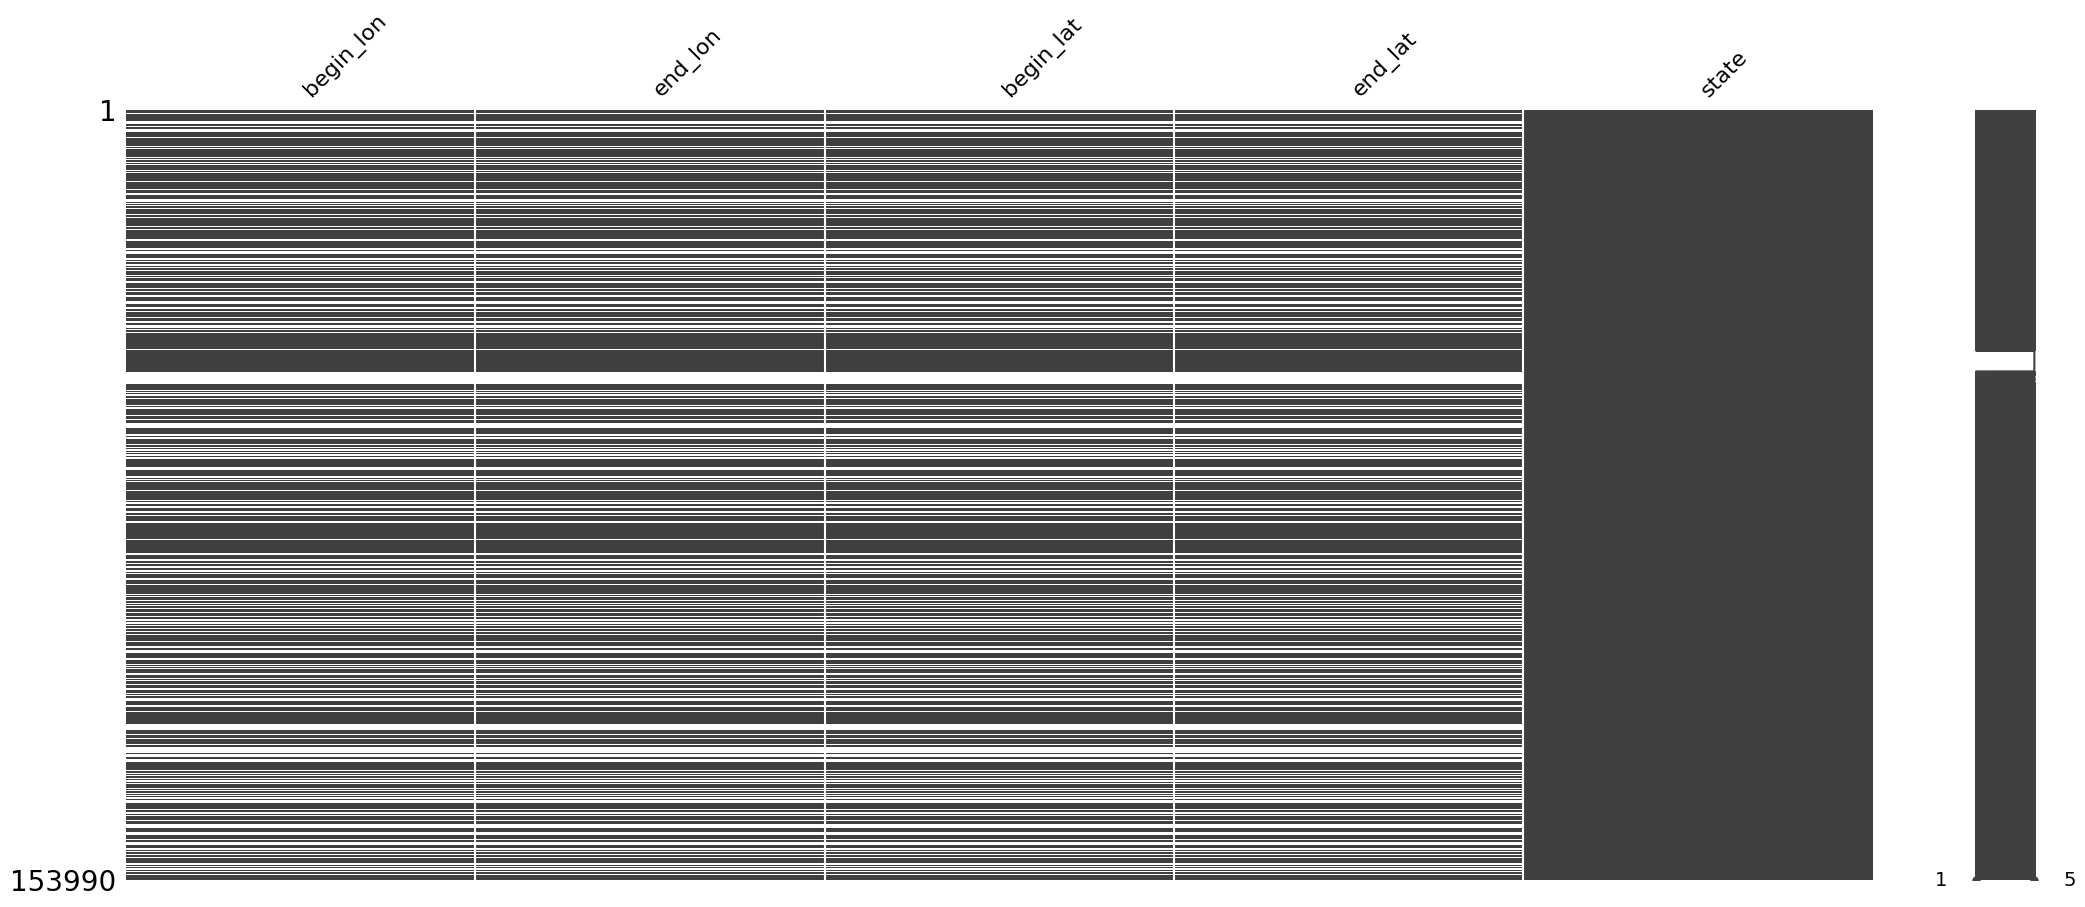

In [17]:
msno.matrix(df_flood_drop[['begin_lon', 'end_lon', 'begin_lat', 'end_lat', 'state']].sort_values('state'))

Missing lat/long for older data, not isolated to specific geographic locations. What percentage of each year is missing? 

In [18]:
df_missingloc = df_flood_drop.loc[df_flood_drop[['begin_lon', 'end_lon', 'begin_lat', 'end_lat']].isna().sum(1) == 4, :]
df_missingloc['year'].value_counts().sort_index()  / df_flood_drop.groupby('year').count()['event_id'] * 100

year
1996    100.000000
1997    100.000000
1998    100.000000
1999    100.000000
2000    100.000000
2001     96.596367
2002    100.000000
2003     95.012107
2004     96.599914
2005     24.605452
2006     63.469493
2007           NaN
2008           NaN
2009           NaN
2010           NaN
2011           NaN
2012           NaN
2013           NaN
2014           NaN
2015           NaN
2016           NaN
2017           NaN
2018           NaN
2019           NaN
2020           NaN
2021           NaN
dtype: float64

Looks like most missing data is in early years. We'll drop missing for now, but note the percentage of missing lat/long for 2001 - 2006 may make those years less helpful. Nan in 2007 on becuase no missing values. 

In [19]:

df_flood_drop2 = df_flood_drop.dropna(subset=['begin_lon', 'end_lon', 'begin_lat', 'end_lat'])
print('number floods before dropping missing locs:', len(df_flood_drop), 'number floods after dropping:', len(df_flood_drop2))

number floods before dropping missing locs: 153990 number floods after dropping: 103535


## Download shapefiles of each Zip Code Tabulation Area

In [20]:
#import 2020 census zip code tabulation areas
zcta = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2020/ZCTA520/tl_2020_us_zcta520.zip')
zcta.head()

ZCTA5CE20 GEOID20 CLASSFP20 MTFCC20 FUNCSTAT20    ALAND20  AWATER20  \
0     35592   35592        B5   G6350          S  298552385    235989   
1     35616   35616        B5   G6350          S  559506992  41870756   
2     35621   35621        B5   G6350          S  117838488    409438   
3     35651   35651        B5   G6350          S  104521045    574316   
4     36010   36010        B5   G6350          S  335675180    236811   

    INTPTLAT20    INTPTLON20  \
0  +33.7427261  -088.0973903   
1  +34.7395036  -088.0193814   
2  +34.3350314  -086.7270557   
3  +34.4609087  -087.4801507   
4  +31.6598950  -085.8128958   

                                            geometry  
0  POLYGON ((-88.24735 33.6539, -88.24713 33.6541...  
1  POLYGON ((-88.13997 34.58184, -88.13995 34.582...  
2  POLYGON ((-86.81659 34.3496, -86.81648 34.3496...  
3  POLYGON ((-87.53087 34.42492, -87.53082 34.429...  
4  POLYGON ((-85.95712 31.67744, -85.95676 31.677...

In [46]:
# Census TIGER files use NAD83
zcta.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

Create point geometry for each flood event, join with zcta polygon. 

In [ ]:
#### merge zcta data to flood dataset
## create point geometry, use flood begin coordinates (puts event closer to flood source)
df_loc = pd.DataFrame([Point(str(x),str(y)) for x, y in zip(df_flood['begin_lon'], df_flood['begin_lat'])], columns=['locstr'])
df_loc.index = df_flood_drop['event_id']

# convert to geodataframe with coordinate system WGS84, ie Lat/long
gdf_flood = gpd.GeoDataFrame(df_loc, geometry='locstr', crs='EPSG:4326')
gdf_flood.to_crs('EPSG:4269', inplace=True) #reproject to NAD83
gdf_zcta = gpd.sjoin(gdf_flood, zcta, how='left')


Confirmed visual on maps that events with missing zip code were outside the census mapped ZCTA areas and so were removed. 

In [ ]:
##load census API Key

load_dotenv()
API_KEY = os.getenv('census_api_key')


In [ ]:
##merge zip code back to flood data, remove events with missing zip code

df_flood_zip = df_flood_drop.merge(gdf_zcta[['ZCTA5CE20']], how='inner', left_on='event_id', right_index=True)
df_flood_zip = df_flood_zip.dropna(subset='ZCTA5CE20')
df_flood_zip.head()

In [ ]:
##define census data variables to pull, and the data label

fields_dict = {'NAME': 'Name',
               
               'B19081_001E': 'houseinc_1',
               'B19081_002E': 'houseinc_2',
               'B19081_003E': 'houseinc_3',
               'B19081_004E': 'houseinc_4',
               'B19081_005E': 'houseinc_5',
               'B19081_006E': 'houseinc_top5',
               'B19013_001E': 'med_houseinc_12mon',
               'B19058_001E': 'household_public_assistance1', 
               # 'B19083_001E': 'gini'
              }

fields = ','.join(list(fields_dict.keys()))
names = list(fields_dict.values()) + ['zcta']


In [ ]:
### request data from api, put into dataframe

url = 'https://api.census.gov/data/2022/acs/acs5?get=' + fields + '&for=zip%20code%20tabulation%20area:*&key=' + API_KEY

r_test = requests.get(url)
r_test.json()
df_census = pd.DataFrame(r_test.json()[1::], columns=names)

df_census.head()

In [ ]:
## check outliers

##check for outliers
df_census = df_census.replace(-666666666, np.nan)
census_numeric_names = ['houseinc_1', 'houseinc_2', 'houseinc_3', 'houseinc_4', 'houseinc_5', 'houseinc_top5', 
                        'med_houseinc_12mon', 'household_public_assistance1']

df_census[census_numeric_names] = df_census[census_numeric_names].apply(pd.to_numeric, errors='ignore')

### check numeric outliers
for n in df_census[census_numeric_names].columns:
    plt.hist(df_census[census_numeric_names][n], bins=15)
    plt.xlabel(n)
    plt.show()

In [ ]:
#looks like -666666666 is null value; replace
df_census = df_census.replace(-666666666, np.nan)


### check numeric outliers
for n in df_census[census_numeric_names].columns:
    plt.hist(df_census[census_numeric_names][n], bins=15)
    plt.xlabel(n)
    plt.show()

In [ ]:
### merge census geography info w flood and zcta flood data

df_cen_fl = df_census.merge(df_flood_zip, how='outer', left_on='zcta', right_on='ZCTA5CE20')
df_cen_fl.head().T

In [ ]:
#limit to lower 48 states
states_to_drop = ['GUAM', 'VIRGIN ISLANDS', 'DISTRICT OF COLUMBIA', 'HAWAII', 'ALASKA', 'AMERICAN SAMOA', 'PUERTO RICO']

df_cen_fl_48 = df_cen_fl[~df_cen_fl['state'].isin(states_to_drop)]
df_cen_fl_48.head()


In [ ]:
#check for missing data
print(len(df_cen_fl_48))
df_cen_fl_48.isna().sum()


In [ ]:
# almost 10000 more zip codes with median_household income than quantile income data. 
# median income is highly correlated with the quantile incomes. Drop quantiles
f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(df_census.corr(numeric_only=True), vmin=-1, vmax=1, ax=ax, annot=True, annot_kws={"fontsize":6})
plt.show()

df_cen_fl_48.drop(['houseinc_1', 'houseinc_2', 'houseinc_3', 'houseinc_4', 'houseinc_5', 'houseinc_top5'], axis=1, inplace=True)


In [ ]:
#check for missing data
df_cen_fl_48.isna().sum()

## zip codes with missing flood data
# print(df_cen_fl_48.loc[df_cen_fl_48['event_id'].isna(), :]) ## no floods in this 

# add column to count floods
df_cen_fl_48['flood_count'] = df_cen_fl_48['event_id'].apply(lambda x: 0 if np.isnan(x) else 1)
df_cen_fl_48['flood_count_fall'] = df_cen_fl_48['month_name'].apply(lambda x: 1 if x in ['October', 'November', 'December'] else 0)
df_cen_fl_48['flood_count_winter'] = df_cen_fl_48['month_name'].apply(lambda x: 1 if x in ['January', 'February', 'March'] else 0)
df_cen_fl_48['flood_count_spring'] = df_cen_fl_48['month_name'].apply(lambda x: 1 if x in ['April', 'May', 'June'] else 0)

df_cen_fl_48

In [ ]:
df_cen_fl_48['month_name'].unique()

In [ ]:
## narravtive column missing to be replaced with 'None' and No Info Available. 
## Text fields that will need to be converted somehow later anyway. 
df_cen_fl_48 = df_cen_fl_48.fillna({'episode_narrative': 'None', 'event_narrative': 'None', 
                                    'damage_property': 'No Info Available', 'damage_crops': 'No Info Available'
                                   })
##drop null values where household_public_assistance is missing
df_final = df_cen_fl_48.dropna(subset='med_houseinc_12mon')
print('final number of floods:', df_final['flood_count'].sum(), 'number of zip codes:', len(df_final))
df_final.isna().sum()

Some census data is just not available for certain zctas and variables. 
I was able to track down the specific reason these data were not available. 
More information available here: https://www.census.gov/programs-surveys/acs/technical-documentation/data-suppression.html

In [ ]:
##check for duplicates
print('there are ', df_final.duplicated(subset=['zcta', 'event_id', 'year']).sum(), 'duplicates')

Data Transform steps to get ZTCA dataset: 
- Census data
- number of events since 1995
- number of events since 2010
- min, max, median event duration
- median income for state (to be able to account for state differences)
- delta flood
- number of floods by season

In [ ]:
df_final['month_name'].unique()

In [ ]:
### calculate number of events since certain year, and flood duration, compute dataset by zip code

names_to_keep = ['med_houseinc_12mon', 
                 'household_public_assistance1']
names_to_sum = ['flood_count', 'flood_count_fall', 'flood_count_winter', 'flood_count_spring']
d1 = dict.fromkeys(names_to_keep, 'median')
d2 = dict.fromkeys(['state_fips'], 'first') ## keep first state fips as some zip codes have multiple states
d3 = dict.fromkeys(names_to_sum, 'sum')
df_final.loc[:, 'state_fips'] = df_final['state_fips']#.astype('int')

df_zcta = df_final[names_to_keep + names_to_sum + ['state_fips', 'zcta']].groupby('zcta').agg({**d1, **d2, **d3})
df_zcta.rename(columns={'flood_count': 'nflood_total'}, inplace=True)

## calculate decadal floods
df_zcta['nflood_2000s'] = df_final.loc[df_final['year'].between(2000, 2010, inclusive='left'), ['zcta', 'flood_count']].groupby('zcta').sum()
df_zcta['nflood_2010s'] = df_final.loc[df_final['year'].between(2010, 2020, inclusive='left'), ['zcta', 'flood_count']].groupby('zcta').sum()
#fill na with zero floods
df_zcta[['nflood_2000s', 'nflood_2010s']] = df_zcta[['nflood_2000s', 'nflood_2010s']].fillna(0, axis=1)

df_final.loc[:, 'flood_duration'] = (pd.to_datetime(df_final['end_date_time']) - pd.to_datetime(df_final['begin_date_time'])).apply(pd.Timedelta.total_seconds) 
df_final['flood_duration'] = df_final['flood_duration'].fillna(0) # fill rows with no flood info with zero flood duration

df_zcta.loc[:,'flood_dur_hours_median'] = df_final[['zcta', 'flood_duration']].groupby('zcta').median() / 3660.0
df_zcta.loc[:,'flood_dur_hours_min'] = df_final[['zcta', 'flood_duration']].groupby('zcta').min() / 3660.0
df_zcta.loc[:,'flood_dur_hours_max'] = df_final[['zcta', 'flood_duration']].groupby('zcta').max() / 3660.0

df_zcta.head()


In [ ]:
#check missing values
df_zcta.isna().sum()

In [ ]:
##calculate state metrics, median income levels

names_state = ['med_houseinc_12mon', 
                 'household_public_assistance1', 'state_fips']
df_state = df_final[names_state].groupby('state_fips').median()
# df_zcta_state = df_zcta[['state_fips', 'nflood_total', 'nflood_2000s', 'nflood_2010s']].groupby('state_fips').median()
# df_state_merge1 = df_state.merge(df_zcta_state, how='outer', on='state_fips')
df_state.columns = [n + '_state_med' for n in df_state.columns] ##rename columns to merge

df_zcta['zcta'] = df_zcta.index.astype('str')
df_zcta_merged = df_zcta.merge(df_state, how='outer', on='state_fips')
df_zcta_merged.head().T

In [ ]:
print(df_zcta_merged.isnull().sum())
### some of the n floods since date metrics returned no events and have a null, replace with zero

df_zcta_merged.fillna(0, inplace=True)
df_zcta_merged.isnull().sum()


In [ ]:
### save final data

df_final.to_csv('data/01_datawrangling_byflood_out.csv')
df_zcta_merged.to_csv('data/01_datawrangling_byzcta_out.csv')


In [ ]:
f, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(df_zcta_merged.corr(), vmin=-1, vmax=1, ax=ax, annot=True, annot_kws={"fontsize":6})